In [ ]:


!pip install kaggle
from google.colab import files 
#files.open('/content/drive/MyDrive/Colab Notebooks/json kaggle')
files.upload() #download and upload json file



!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d samratalam/stemmed-20-times-dataset

 79% 49.0M/62.2M [00:00<00:00, 242MB/s]
100% 62.2M/62.2M [00:00<00:00, 247MB/s]


In [ ]:
#to unzip file

from zipfile import ZipFile
file_name= "stemmed-20-times-dataset.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
#from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
'''
!pip install wandb
import wandb
wandb.init()
'''

'\n!pip install wandb\nimport wandb\nwandb.init()\n'

In [ ]:
df=pd.read_csv('/content/strem_20_times_data_clen.csv')

df.drop(columns=['Unnamed: 0'],inplace=True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.iloc[95119]['Sentence']

'প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শূন্যস্থান পূরণ নম্বর প্রভাষক ঢাকা রেসিডেনসিয়াল মড কলেজ'

# **Dataframe Null value **

In [ ]:
df.loc[df['length'] <= 100]

,Sentence,Sentiment,length
95117,ইংরেজি পত্র লেসন প্রি শিক্ষার্থী ইংরেজি পত্র ল...,4,100
95118,প্রি শিক্ষার্থী ইংরেজি পত্র নম্বর প্রশ্ন আলোচন...,4,100
95119,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শ...,4,100
95120,প্রি শিক্ষার্থী ইংরেজি পত্র চর্চা কর মি নেব শি...,4,100
95121,রিয়াজুল বাশ মাহমুদ শরীফ বিডিনিউজ টোয়েন্টিফোর ড...,6,100
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.drop(df[df['length'] < 100].index, inplace = True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95125,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
95126,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
95127,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
95128,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df = df.drop_duplicates('Sentence', keep='first')

df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
2,ঢাকা শহর আতঙ্ক শহর দিনরাত সবখান মৃত্যুর অশুভ ছ...,1,31688
3,এটিএন বাংলা ঈদ অনুষ্ঠানমালা ছয়দিন দশ পর্ব নাটক...,11,26534
4,কথা কথা কথা পাব অ্যাকটিং ভালো রপ্ত কর ওশোর পাত...,11,21860
...,...,...,...
88674,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
88675,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
88676,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
88677,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [ ]:
df.isna().sum().sum()

0

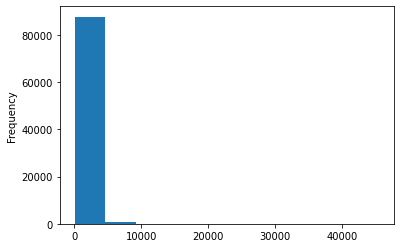

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
df.Sentiment.reset_index(drop=True, inplace=True)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
8      7684
0      6126
7      5036
6      3754
3      3389
10     2810
1      2170
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


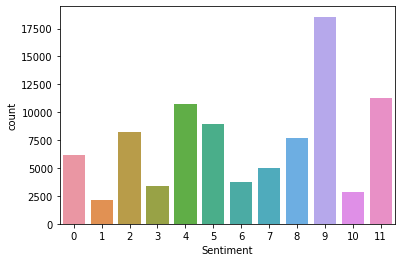

In [ ]:
sns.countplot(df['Sentiment']);

# **bnltk 0.7.6 Stemmer**

**New Stemmed**

In [ ]:
uniqueWords = list(set(" ".join(df['Sentence']).split(" ")))
count = len(uniqueWords)
print(count)

332301


In [ ]:
df['Sentence'] = df['Sentence'].astype('str') 
df.reset_index(drop=True, inplace=True)
#df['Sentence'] = df['Sentence'].astype('str')

In [ ]:

#df['Sentence'] = df.Sentence.apply(lambda x: Stemming(str(x)))

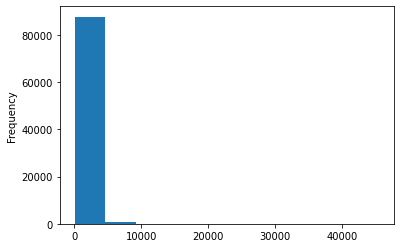

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
from collections import Counter
#Counter(" ".join(df["Sentence"]).split()).most_common(1000)  
#NOT FASTER 

In [ ]:
#pd.Series(' '.join(df['Sentence']).lower().split()).value_counts()[:10000] #faster AND for large amounts of text/rows

# **Shuffle the data**

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
8      7684
0      6126
7      5036
6      3754
3      3389
10     2810
1      2170
Name: Sentiment, dtype: int64

In [ ]:
train1, test1 = train_test_split(df,random_state=22, test_size=0.2)
training_sentences = []
testing_sentences = []




train_sentences=train1['Sentence'].values
train_labels=train1['Sentiment'].values
#for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
 #   x=str(train_sentences[i])
 #   training_sentences.append(x)

 
    
#training_sentences=np.array(training_sentences)





test_sentences=test1['Sentence'].values
test_labels=test1['Sentiment'].values
#y = pd.get_dummies(data1['Sentiment']).values

train_labels=pd.get_dummies(train_labels).values
test_labels=pd.get_dummies(test_labels).values


print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 70943
Testing Set Length: 17736
training_sentences shape: (70943,)
testing_sentences shape: (17736,)
train_labels shape: (70943, 12)
test_labels shape: (17736, 12)


In [ ]:
train_labels

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
print(train_sentences[10])
print(train_labels[0])

বহুনির্বাচনি প্রশ্ন প্রি শিক্ষার্থী রসায়ন বিষ বহুনির্বাচনি প্রশ্নোত্তর অধ্যা নিচ অধাতু আয়রন সিলভ সালফ কপ সালফ সর্বপ্রথম বস্তু প্রধান শ্রেণী ভাগ নিউটন ল্যাভয়সি বার্জেলিয়াস অ্যাভোগেড্রো ল্যাভয়সি সমসত্ত্ব মিশ্রণ উদাহরণ পানি বালু লোহ গুঁড়া সাগর পানি সোনা সাগর পানি লোহা দীর্ঘদিন বাতাস দিল ওপর রঙ আস্তরণ পড় ধরন পরিবর্তন ধুলাবালির স্তর ভৌত পরিবর্তন বিশুদ্ধ লোহা রাসায়নিক পরিবর্তন রাসায়নিক পরিবর্তন আন্তআণবিক শক্তি বস্তুর ওপর নির্ভর দৈর্ঘ্য প্রস্থ প্রকৃতির ওপর ওপর প্রকৃতির ওপর নিচ উপধাতু পারদ বোরন জিংক কপ বোরন শুষ্ক বরফ সংকেত লোহ টুক চুম্বক ঘর্ষণ চুম্বকত্বপ্রাপ্ত ধরন পরিবর্তন ভৌত রাসায়নিক পরিবর্তন রাসায়নিক পরিবর্তন তাপ পরিবর্তন ভৌত পরিবর্তন ভৌত পরিবর্তন নিচ রাসায়নিক পরিবর্তন পানি চিনির সংযোগ শরবত তৈরি বরফ পানি তৈরি লোহা মরিচা পড়া চুম্ব ঘষ লোহ টুক চুম্ব রূপান্তরিত লোহা মরিচা পড়া অধ্যা আধুনিক রসায়ন প্রতিষ্ঠাতা ডেমোক্রিটাস অ্যারিস্টটল ল্যাভয়েসি ডাল্টন ডেমোক্রিটাস ডাল্টন পরমাণুবাদ প্রকাশিত সাল সাল সাল সাল সবচা ভারী মৌল হাইড্রোজ হিলিয়াম ইউরেনিয়াম মারকারি ইউরেনিয়াম পরমাণু অণুর সংজ্ঞা প্রদান বিজ্ঞানী অ্

In [ ]:
vocab_size = 200000
embedding_dim = 300
max_length = 4000
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

(70943,)
(70943, 12)


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#451606 words in raw dataset
#434245 words in raw dataset after stopwords removal
#339313 after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

293096
Word index length:293096


In [ ]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

সাভ রানা প্লাজা ট্র্যাজেডি ঘট মঙ্গোলিয় রাজধানী উলানবাটোর দেশ সমন্বয় গঠিত কমিউনি অব ডেমোক্রেসি আয়োজিত সপ্তম মিনিস্টারিয়াল কনফারেন্স নিচ্ছিলাম কনফারেন্স সা পৃথিবী ব্যক্তি শান্তি নোব বিজয়ী অং সান সু চি তাওয়াক্কল কারমান একাধিক দেশ প্রেসিডেন্ট ভাইস প্রেসিডেন্ট প্রধানমন্ত্রী মন্ত্রিপরিষ জাতিসংঘ কর্মকর্তা রাষ্ট্রদূত পার্লামেন্টারিয়ান সিভিল সোসা ব্যবসায়ী নারী প্রতিনিধি বাংলাদেশ একমাত্র অনুষ্ঠান নিয়েছিলাম চীন নিযুক্ত বাংলাদেশ রাষ্ট্রদূত সরক প্রতিনিধিত্ব রানা প্লাজা ট্র্যাজেডির ব্যাপকতা সম্পর্ জানাজানি থাকল কনফারেন্স অংশগ্রহণকারী ব্যক্তি সমবেদনা এগিয় আস হোট রুম সিএনএন বিবিসি চাযা দুর্ঘটন উদ্ধ কার্যক্রম চরমভাব ব্যথিত সমবেদনা জ্ঞাপনকারী ব্যক্তি বাংলাদেশ তৈরি পোশাক ভোক্তা অমানবিক পািা তৈরি মর্মাহত একজন হতাশ সুর বল গায় জামা মেয় বানিয় মৃত নিখোঁজ কয়েকজন দুর্ঘটন প্রকৃত ধরন বিপর্যয় রোধ সরক ভূমিকা সম্পর্ প্রশ্ন সরক উদ্ধারকাজ ব্রিটিশ সহায়তা নিল দায়ী ব্যক্তি চিহ্নিত শাস্তি পা মৃত ব্যক্তি পরিবারপরিজন আহত ব্যক্তি দায়ভ নাবা সম্মেলন একজন আমেরিকান কথা বাংলাদেশ তৈরি পোশাকশিল্প স

In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (70943, 4000)
Padded shape(testing): (17736, 4000)


In [ ]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
#model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Flatten())




#model.add(Flatten())
#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
#model.add(Flatten())
model.add(Dense(12, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
#lstm

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4000, 300)         60000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 4000, 128)         186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2580      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                252       
Total params: 60,288,528
Trainable params: 60,288,528
Non-trainable params: 0
____________________________________________

In [ ]:
history=model.fit(padded,train_labels,epochs=5,batch_size=128,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
555/555 [==============================] - 951s 2s/step - loss: 1.9394 - accuracy: 0.4425 - val_loss: 1.3016 - val_accuracy: 0.6560
Epoch 2/5
555/555 [==============================] - 921s 2s/step - loss: 1.0379 - accuracy: 0.7218 - val_loss: 0.9349 - val_accuracy: 0.7566
Epoch 3/5
555/555 [==============================] - 920s 2s/step - loss: 0.7555 - accuracy: 0.8099 - val_loss: 0.8851 - val_accuracy: 0.7698
Epoch 4/5
555/555 [==============================] - 922s 2s/step - loss: 0.6739 - accuracy: 0.8376 - val_loss: 0.8075 - val_accuracy: 0.8017
Epoch 5/5
555/555 [==============================] - 926s 2s/step - loss: 0.4612 - accuracy: 0.9046 - val_loss: 0.7527 - val_accuracy: 0.8160


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


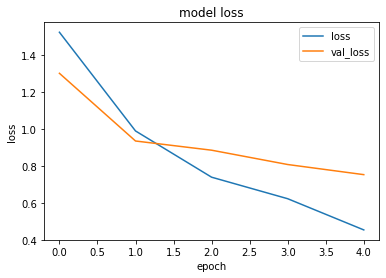

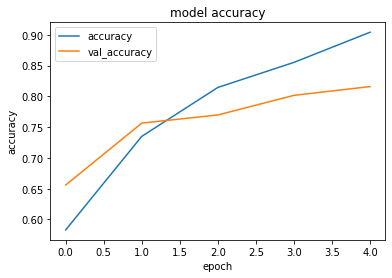

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
predictions = model.predict(testing_padded)
pred1 = np.argmax(predictions , axis=1)

In [ ]:
%%time
score = model.evaluate(testing_padded, test_labels , batch_size = 128)
print()

print("ACCURACY:",score[1])
print("LOSS:",score[0])

139/139 [==============================] - 61s 437ms/step - loss: 0.7527 - accuracy: 0.8160

ACCURACY: 0.8159675002098083
LOSS: 0.7526935935020447
CPU times: user 55.4 s, sys: 6.53 s, total: 1min 1s
Wall time: 1min 21s


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
test_labels = np.argmax(test_labels,axis=1)

In [ ]:
print(confusion_matrix(test_labels , pred1 ,normalize=None))

[[1009    1   95    1   11    7   15    7   16   25    2   13]
 [   3  128    8    3   20  141   69    2   23   10    1   15]
 [  18    2 1467    7   25   24   15   19   20   88    6    8]
 [   2   22    4  427    4    4   31   22   26   32   74    1]
 [   2    8   19    2 1815   26   60    2   93  114    1   23]
 [   4   94   37    7   45 1479   45    2   22   25    4   17]
 [  15   11   34    3   75   18  435    5   61   52    3   10]
 [  10    7   17   25    4    2   20  730  107   14   35   25]
 [   6   12   18    7   88   15   92   22 1181   92    5   12]
 [   9    5   65   13   63   15   41   21  136 3320    8   12]
 [  10    7   17   51    5   15   29   31   17    7  364    4]
 [   4    8   23   15   18   46   10    5    9   26    3 2117]]


In [ ]:
print(classification_report(test_labels , pred1,digits=5))

              precision    recall  f1-score   support

           0    0.92399   0.83943   0.87969      1202
           1    0.41967   0.30260   0.35165       423
           2    0.81319   0.86345   0.83757      1699
           3    0.76114   0.65794   0.70579       649
           4    0.83525   0.83834   0.83679      2165
           5    0.82533   0.83043   0.82788      1781
           6    0.50464   0.60249   0.54924       722
           7    0.84101   0.73293   0.78326       996
           8    0.69024   0.76194   0.72432      1550
           9    0.87254   0.89536   0.88380      3708
          10    0.71937   0.65350   0.68485       557
          11    0.93797   0.92688   0.93239      2284

    accuracy                        0.81597     17736
   macro avg    0.76203   0.74211   0.74977     17736
weighted avg    0.81711   0.81597   0.81534     17736



In [ ]:
accuracy_score(test_labels , pred1)

0.8159675236806495